In [1]:
# to run notebook inside of package
import sys
sys.path.append('/Users/mollyliebeskind/Documents/auto_forecast/auto_forecast')

# standard data manipulation imports
import pandas as pd

# import internal package functions
from src.plotting import *
from src.data_processing import *

In [2]:
value_col = 'sales'
diffed_value_col = f"{value_col}_differenced"
date_col = 'date'
mean_freq = 'Y'
daily_data = pd.read_csv('train.csv')

monthly_data = aggregate_by_time(daily_data, 
                                date_col, 
                                resample_freq='M', 
                                aggregate='sum'
                                )

stationary_data = difference_data(monthly_data, value_col)


# Visualize

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'distrobution of sales per day'}, xlabel='sales per day', ylabel='count'>)

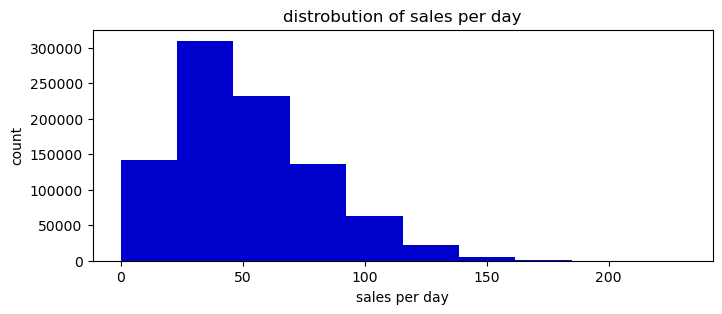

In [3]:
plot_periodic_values_hist(daily_data, value_col)

(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'sales per group'}, xlabel='group id', ylabel='summed value for the group'>)

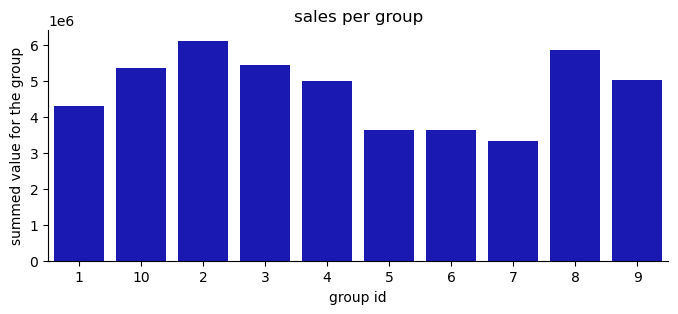

In [4]:
plot_values_per_group(daily_data, value_col, ['store'])

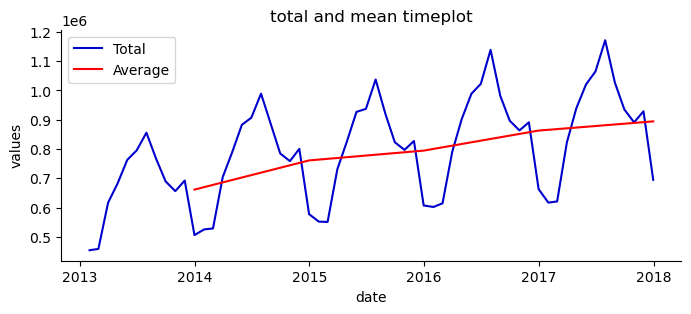

In [5]:
plot_time_series(monthly_data, date_col, value_col, mean_freq)

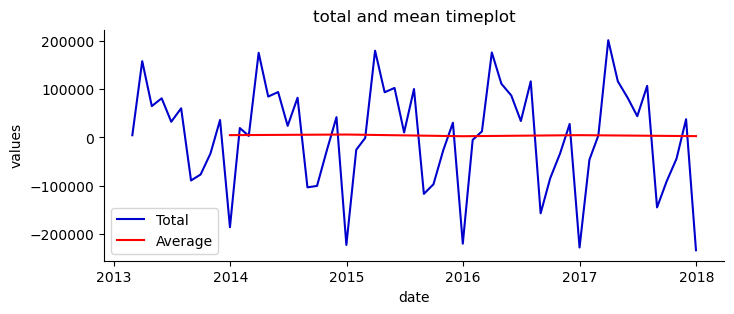

In [8]:
plot_time_series(stationary_data, date_col, diffed_value_col, mean_freq)

/Users/mollyliebeskind/opt/miniconda3/envs/auto-forecasting/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


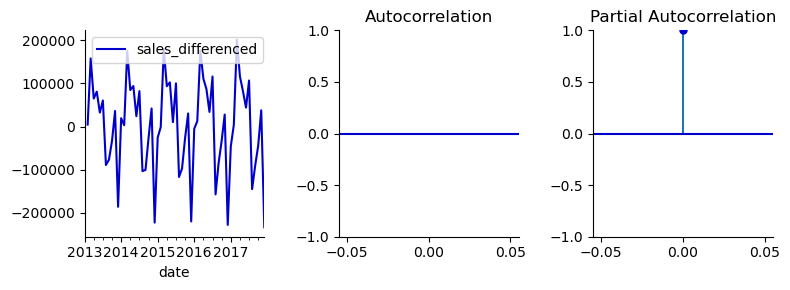

In [9]:
plt_acf_pcf(stationary_data, date_col, diffed_value_col, lags=13)